# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
toggle_cell()

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/uk/middle_wallop/dat.txt'
# ipath= './data/NCDC/uk/southhamption/dat.txt'
# ipath= './data/NCDC/uk/bournemouth/dat.txt'
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/uk/holbeach/dat.txt"
# ipath= "./data/NCDC/uk/weybourne/dat.txt"
# ipath= "./data/NCDC/uk/cambridge/dat.txt"
# ipath= "./data/NCDC/uk/wattisham/dat.txt"
# ipath= "./data/NCDC/uk/lakenheath/dat.txt" # irregular sampling time
# ipath= "./data/NCDC/uk/mildenhall/dat.txt" # irregular sampling time

# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # recent 5 year maybe corrupted
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # high initial data
# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # corrupted
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt"  
# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt" # hard to fit
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # truncate, irregular sample time
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt" # truncate
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # truancate dataset, try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # has 0 speed records
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem, weird direction distribution

# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; narror ellipse
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt"
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # 16 sectors

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # 
# ipath= "./data/NCDC/cn/luogang/dat.txt"  # 
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # chi square 有问题
# ipath= "./data/NCDC/cn/wusu/dat.txt" # chi square 有问题, bandwidth 过小
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # 
ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" # good
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real
# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # Wrong data

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,2.813470e+05,281347.000000,281347.00000,281347.000000,281347.000000
mean,2.001544e+07,1106.450579,181.14116,3.947066,158.748975
std,9.786473e+04,681.443079,114.82452,1.800596,107.843629
min,1.980010e+07,0.000000,0.00000,0.500000,0.000000
25%,1.993113e+07,500.000000,80.00000,3.000000,70.000000
50%,2.003082e+07,1100.000000,160.00000,4.000000,140.000000
75%,2.010111e+07,1700.000000,300.00000,5.000000,250.000000
max,2.015030e+07,2357.000000,359.00000,30.000000,350.000000


False


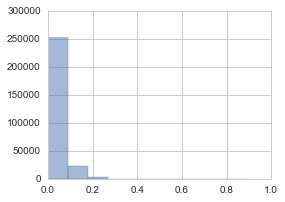

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

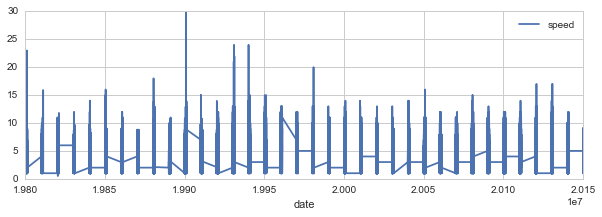

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

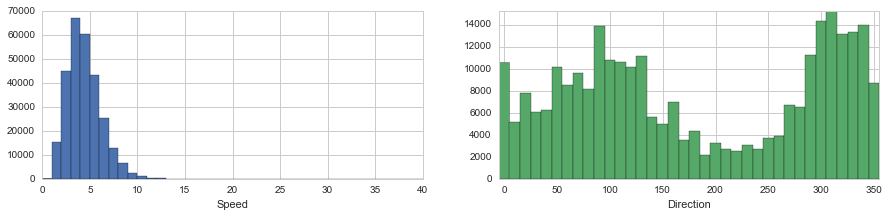

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,
19940128,19940128,0,FM-15,119,3.0,331,0.0
19940718,19940718,1000,FM-15,337,5.0,113,0.0
19940805,19940805,1100,FM-15,335,9.0,115,0.0
19940810,19940810,500,FM-15,319,10.0,131,0.0
19940903,19940903,2100,FM-15,331,5.0,119,0.0
19941203,19941203,1400,FM-15,316,3.0,134,0.0
19950403,19950403,1300,FM-15,337,3.0,113,0.0
19980603,19980603,1100,FM-15,59,10.0,31,0.0
19980909,19980909,1200,FM-15,359,20.0,91,0.0


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19900917,19900917,0,SY-MT,130,30.0,320,0.0,27.9,24.9
19931012,19931012,2300,FM-16,320,24.0,130,0.0,22.0,20.0
19940127,19940127,2300,FM-16,170,24.0,280,0.0,21.0,20.0
19801008,19801008,2100,FM-12,0,23.0,90,0.0,21.0,19.0
19931221,19931221,2200,FM-15,110,22.0,340,0.0,19.0,20.0
19800714,19800714,900,FM-12,280,22.0,170,0.0,20.0,20.0
19930802,19930802,1400,FM-15,140,21.0,310,0.0,17.0,19.0
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0


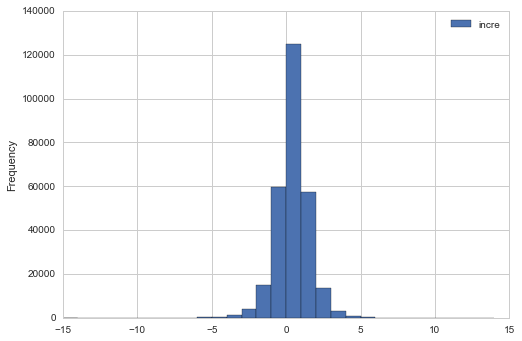

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 9


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20120808,20120808,530,FM-15,0,17.0,90,0.0,2.0,4.0
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0
19850430,19850430,800,FM-15,310,16.0,140,0.0,9.8,11.0
20050911,20050911,1700,FM-15,0,16.0,90,0.0,4.0,4.0
19811219,19811219,700,FM-15,140,15.9,310,0.9,7.9,3.1
19811219,19811219,500,SY-MT,140,15.9,310,0.9,7.9,7.9
19850312,19850312,900,SY-MT,0,15.0,90,0.0,9.9,10.9
19910209,19910209,600,SY-MT,200,15.0,250,0.0,10.9,9.9


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0      10555
10      5130
20      7804
30      6064
40      6251
50     10110
60      8530
70      9575
80      8128
90     13902
100    10757
110    10636
120    10161
130    11167
140     5624
150     4938
160     6934
170     3546
180     4387
190     2173
200     3221
210     2703
220     2529
230     3030
240     2716
250     3684
260     3877
270     6740
280     6489
290    11213
300    14350
310    15205
320    13146
330    13326
340    13999
350     8728
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

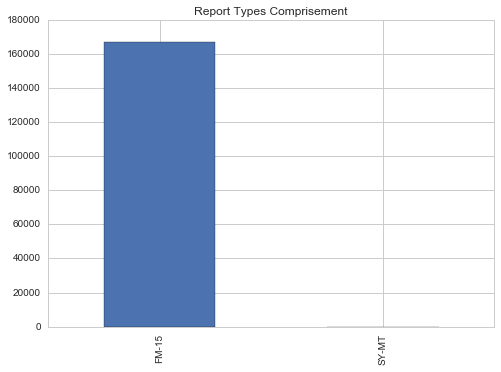

In [14]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

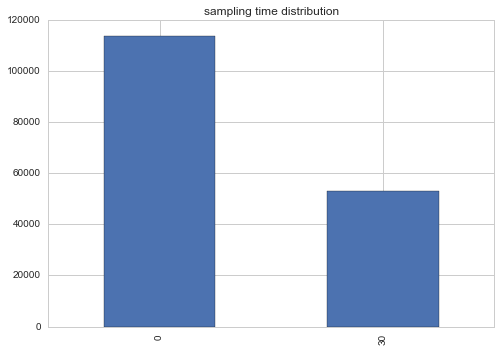

In [15]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = sample_time.value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0       7027
100     8319
200     8613
300     7538
400     8951
500     8956
600     7690
700     9245
800     9308
900     7970
1000    8956
1100    8634
1200    7622
1300    8263
1400    7913
1500    6972
1600    7328
1700    7150
1800    6498
1900    6973
2000    6956
2100    6562
2200    7283
2300    7508
Name: HrMn, dtype: int64

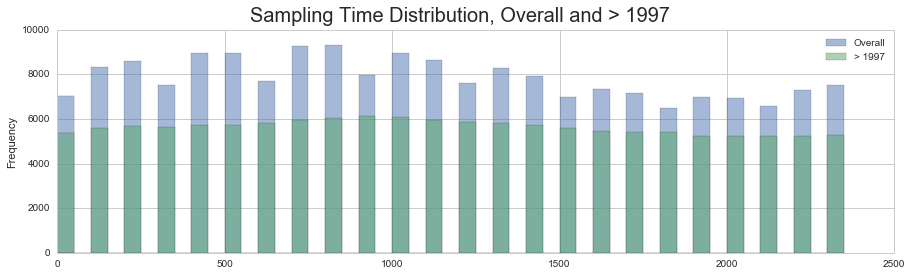

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

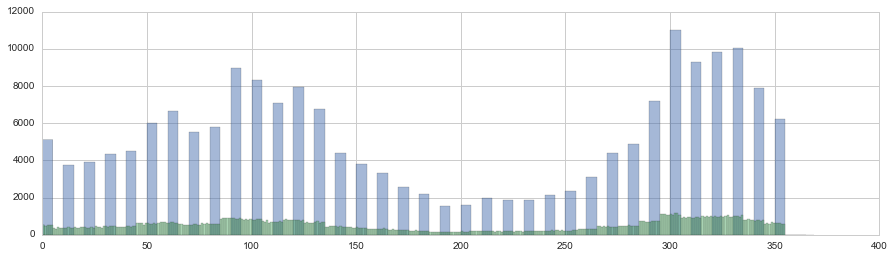

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

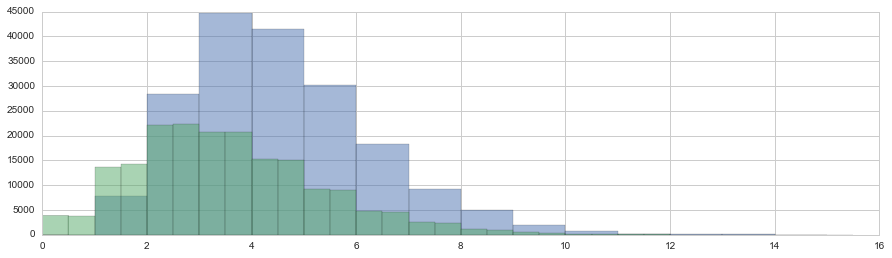

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

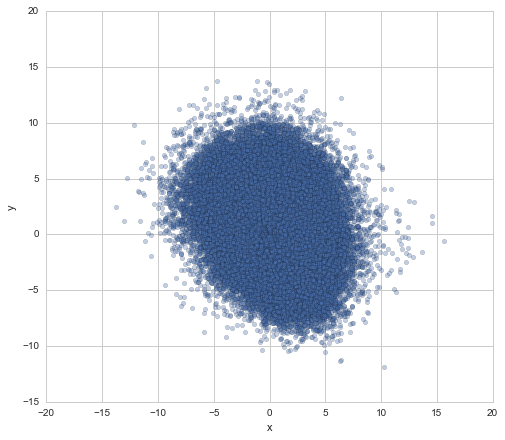

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

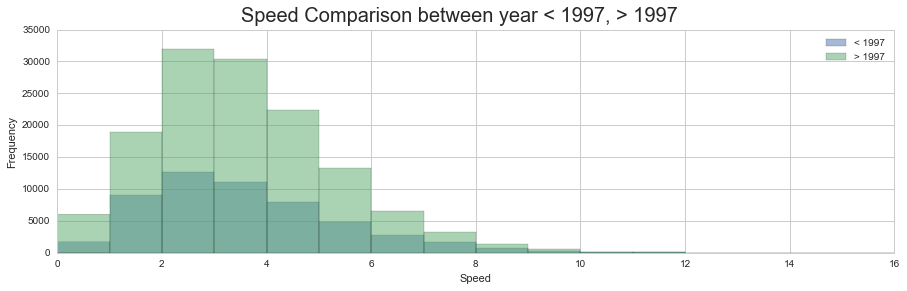

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

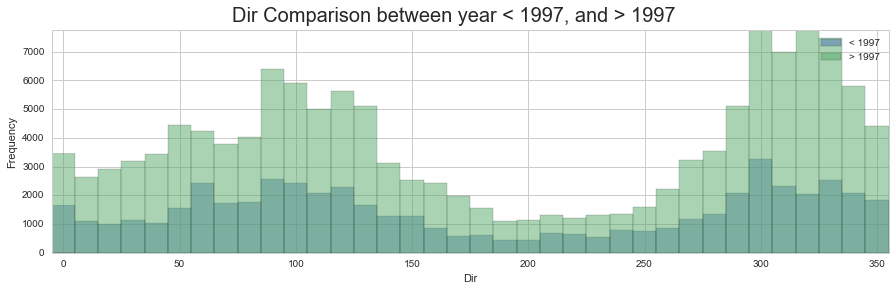

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

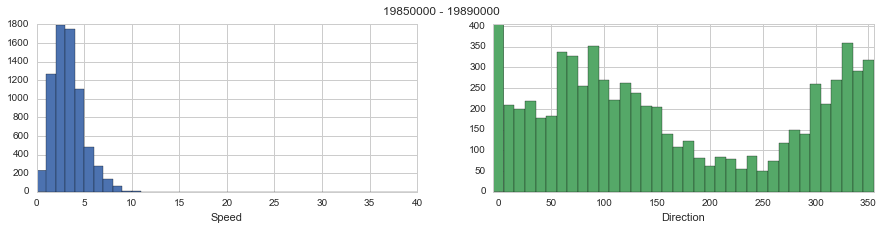

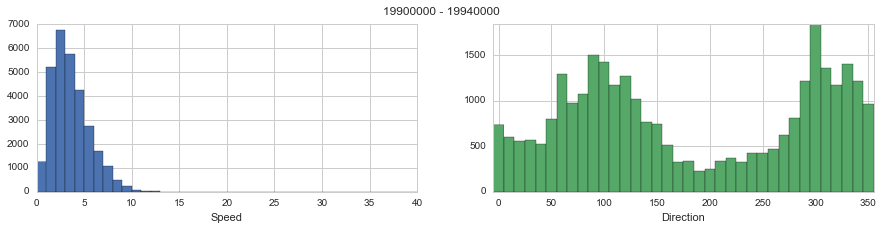

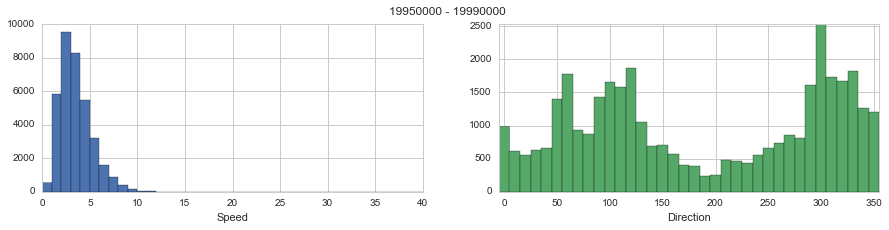

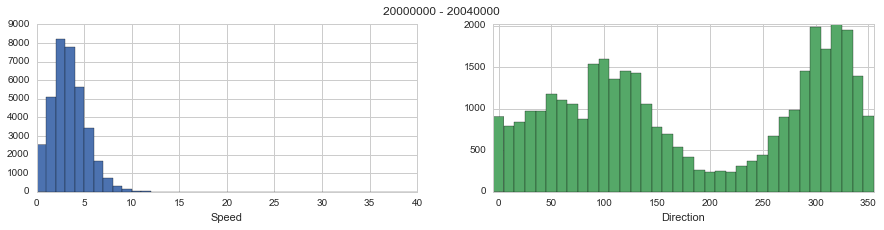

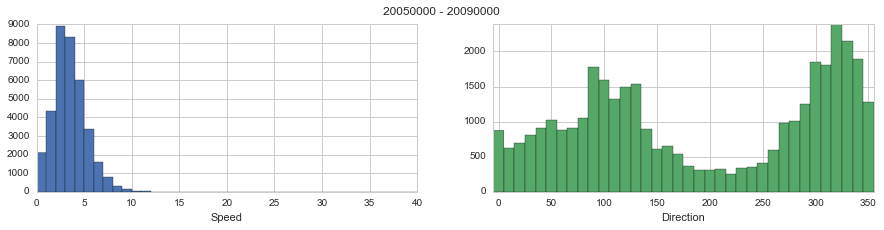

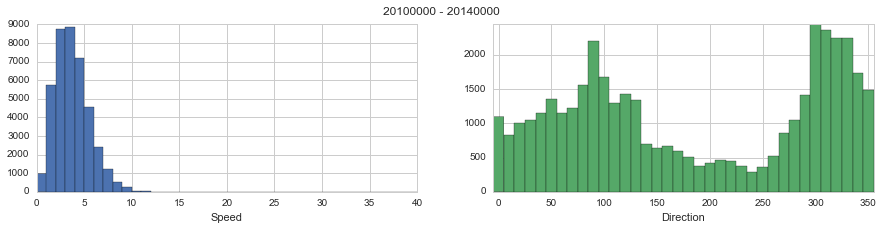

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 10
Report type used: FM-15
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,4.057000e+04,40570.000000,40570.000000,40570.000000,40570.000000,40570.0,40570.000000,40570.000000,40570.000000,40570.000000
mean,2.012083e+07,1137.670693,184.915550,3.746480,152.993098,0.0,0.008578,0.008430,0.882498,0.375708
std,1.407122e+04,685.007356,115.984697,1.831586,106.550156,0.0,0.886869,0.897068,2.523288,3.178710
min,2.010010e+07,0.000000,-4.999973,0.000320,0.000000,0.0,-9.000000,-12.000000,-11.544220,-10.118602
25%,2.011041e+07,600.000000,83.009195,2.385673,70.000000,0.0,0.000000,0.000000,-0.645676,-1.894503
50%,2.012071e+07,1100.000000,163.641893,3.534096,130.000000,0.0,0.000000,0.000000,1.157859,0.100285
75%,2.013093e+07,1700.000000,304.705182,4.847568,230.000000,0.0,1.000000,1.000000,2.680965,2.699659
max,2.014123e+07,2300.000000,354.999241,14.661879,350.000000,0.0,8.000000,8.000000,14.568613,12.926302


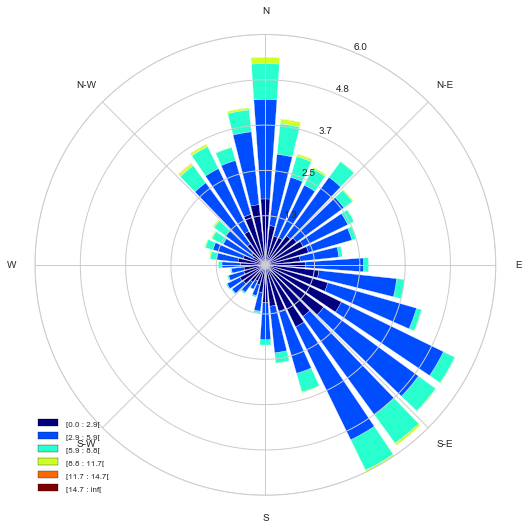

In [27]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

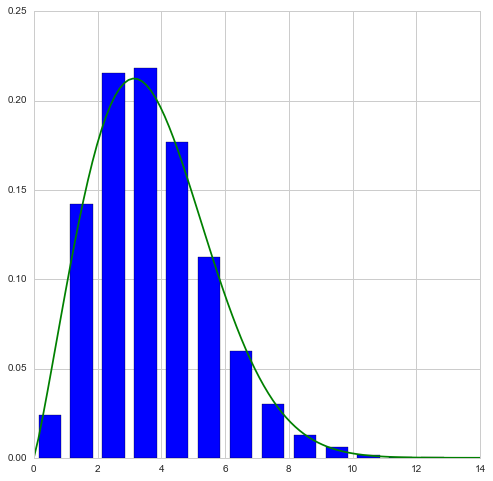

In [28]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

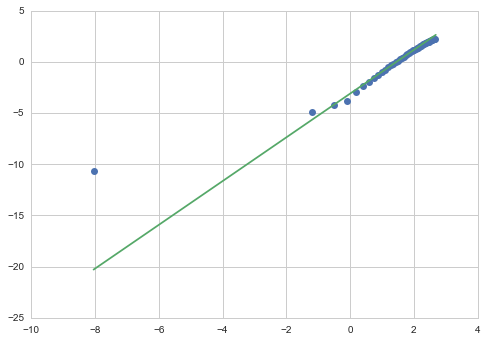

In [29]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [30]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7

In [31]:
FITTING_RANGE = []
fit_limit = ceil(df['speed'].quantile(.95))
plot_limit = ceil(df['speed'].quantile(.975))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])
        
print fitting_axis_range

[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]


# 3. Kernel Density Estimation

In [32]:
sample = SPEED_SET

In [33]:
# The bandwidth value sometimes would be too radical
from sklearn.grid_search import GridSearchCV

if knot_unit:
    bandwidth_range = arange(0.5,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

grid = GridSearchCV(neighbors.KernelDensity(),
                    {'bandwidth': bandwidth_range},
                    n_jobs=-1, cv=4) 
grid.fit(sample)
bandwidth = grid.best_params_['bandwidth']

In [34]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH 

kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 0.6 289
[  9.81014996e-09   1.28022237e-08   2.18460768e-08   6.56573621e-07
   5.71506762e-06]


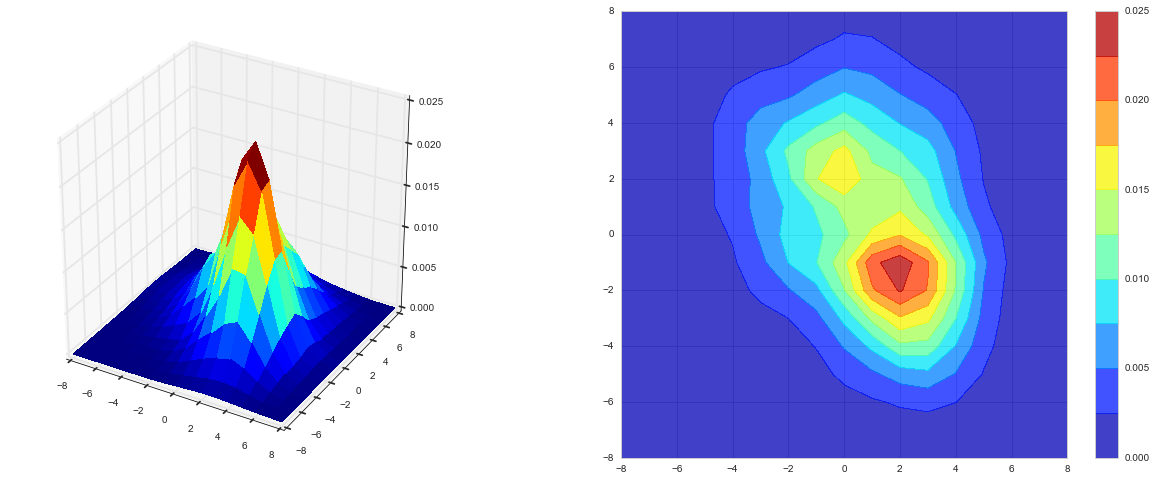

In [35]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [36]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [37]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [38]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.410025,2.075665,-1.811363,1.657908,2.208181,-0.232211
2,0.300650,1.443657,2.544409,2.169093,2.778685,-0.209868
3,0.289325,-1.391553,1.221580,2.389284,2.758762,-0.243203


GMM Plot Result
0.410024577675 [[ 2.07566503 -1.81136278]] [ 1.56546692  2.27465087] -160.683980576
0.300650204701 [[ 1.44365687  2.54440894]] [ 2.06026963  2.86030511] -160.005505067
0.289325217624 [[-1.3915533   1.22158035]] [ 2.1899257   2.91953228] -150.339606633


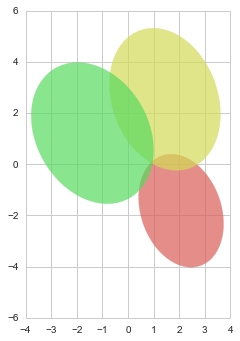

In [39]:
plot_gmm_ellipses(gmm_em_result)

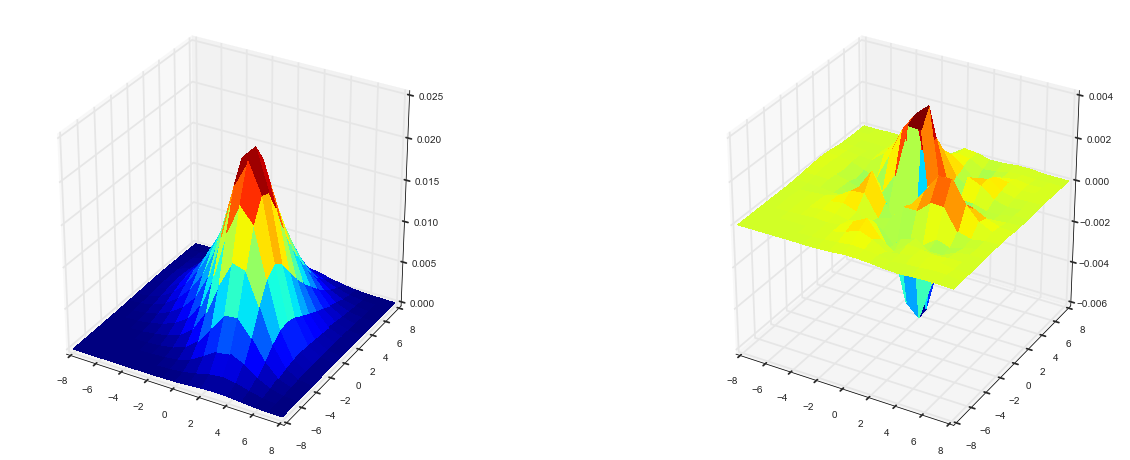

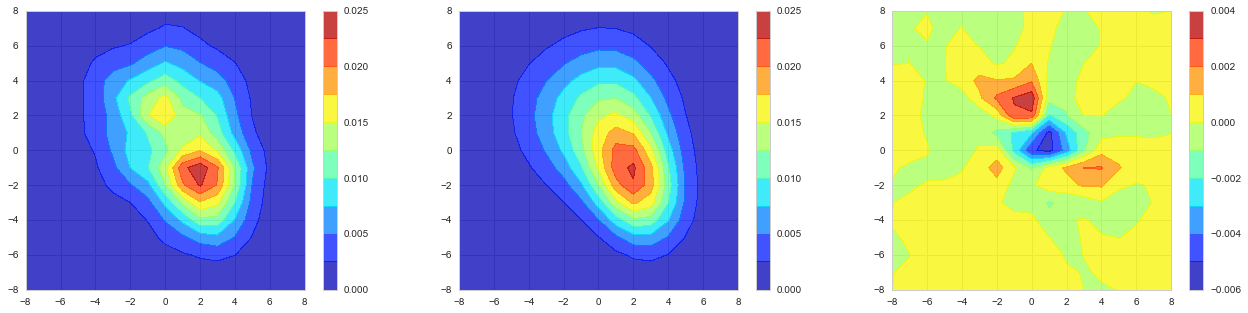

In [40]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [41]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022539,0.024684,7.496648e-07,0.035697,0.25238,0.969343


# 5. Least Square Prob Estimation

In [42]:
sample = SPEED_SET
points = FITTING_RANGE

In [43]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
        # {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        # {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points,FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -15.110060481750203
     jac: array([ -2.09819794e-01,   2.38418579e-07,   0.00000000e+00,
        -1.19209290e-07,   0.00000000e+00,   0.00000000e+00,
        -2.09818959e-01,   0.00000000e+00,   5.96046448e-07,
        -4.76837158e-07,   0.00000000e+00,   4.76837158e-07,
        -2.09816694e-01,   1.19209290e-07,  -1.19209290e-07,
        -1.19209290e-07,   1.19209290e-07,  -1.19209290e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1308
     nit: 64
    njev: 64
  status: 0
 success: True
       x: array([ 0.58782872,  0.0355386 ,  1.98642091,  2.79166753,  2.97410511,
        0.01984622,  0.38350606,  2.26846621, -1.95190009,  1.60831492,
        1.96701306, -0.05971615,  0.02866522, -0.44922565,  2.67084664,
        0.99458656,  0.78701216, -0.03152739])

## 5.1 GMM Result

In [44]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.587829,0.035539,1.986421,2.791668,2.974105,0.019846
2,0.383506,2.268466,-1.951900,1.608315,1.967013,-0.059716
3,0.028665,-0.449226,2.670847,0.994587,0.787012,-0.031527


GMM Plot Result
0.587828723595 [[ 0.0355386   1.98642091]] [ 2.787149    2.97834002] 171.302194489
0.383506056963 [[ 2.26846621 -1.95190009]] [ 1.59982094  1.97392762] -171.792113016
0.0286652194414 [[-0.44922565  2.67084664]] [ 0.78596985  0.99541044] -93.8009501319


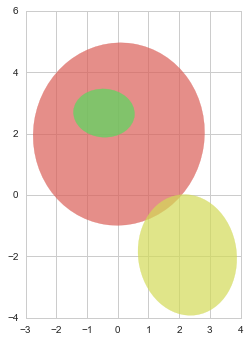

In [45]:
plot_gmm_ellipses(gmm)

## 5.2 Goodness-of-fit statistics

In [46]:
pretty_pd_display([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.023405,0.015188,2.740212e-07,0.021582,0.152585,0.988794


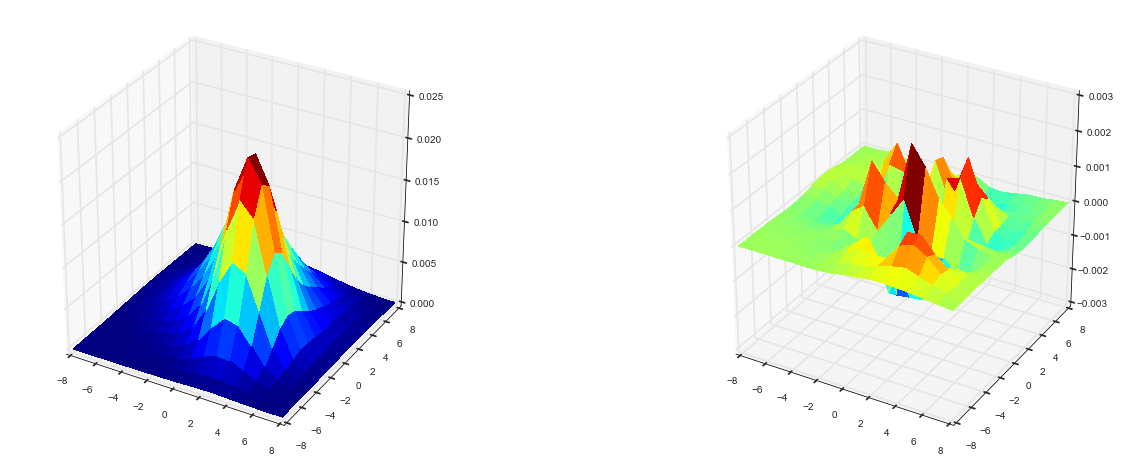

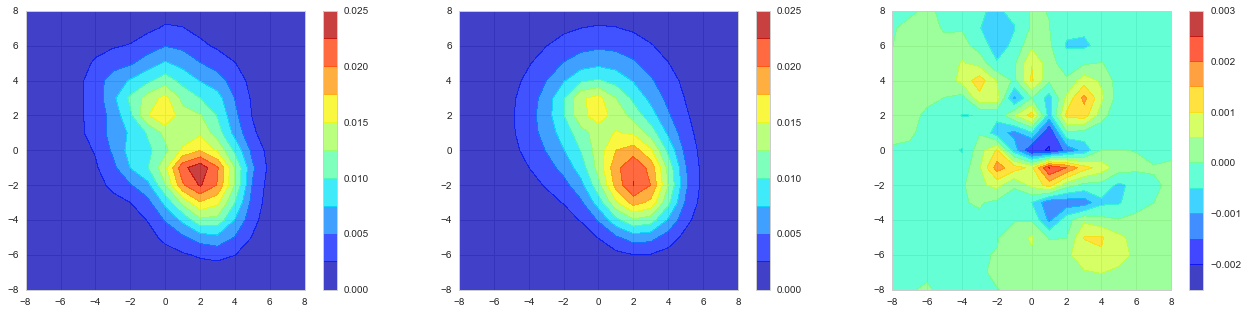

In [47]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [48]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

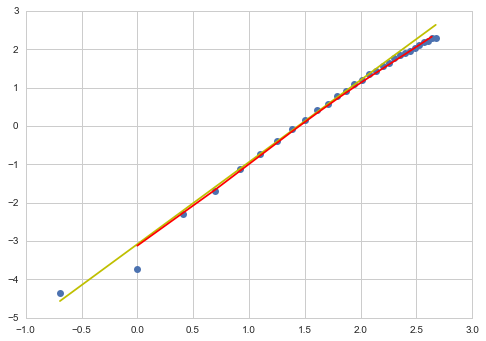

In [49]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

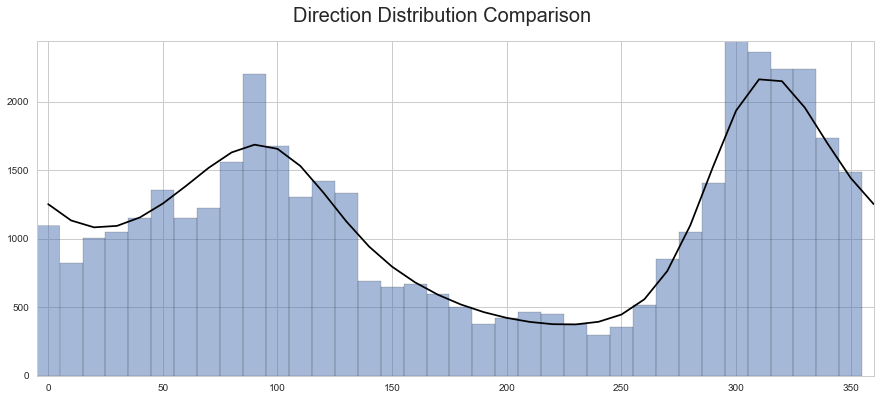

In [50]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

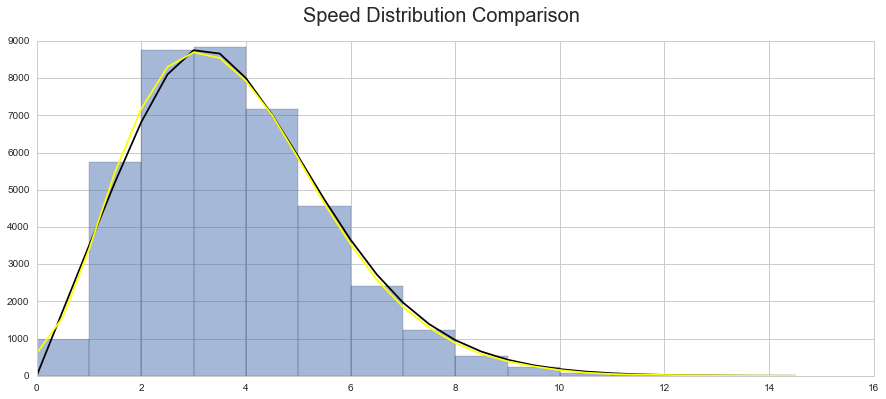

In [51]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

## 5.3 Sectoral Comaprison

In [61]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, 
                                         [[0, inf],
                                          [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = linspace(0, sub_max_speed, 20)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],
                   [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x = linspace(0, sub_max_speed, 20)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,3,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. Weibull plot
        ax4 = fig.add_subplot(1,3,3)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'data size:', len(sub_df)
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

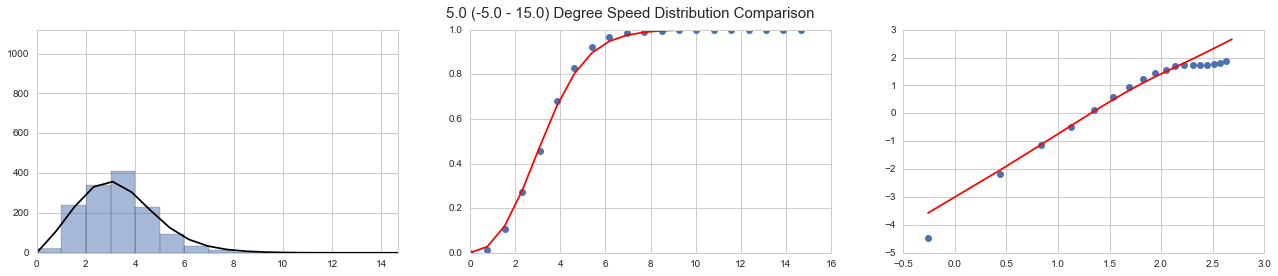

data size: 1395
max diff: 0.0261446448807 , speed value: 5.40174473206 y gmm 0.895719154402

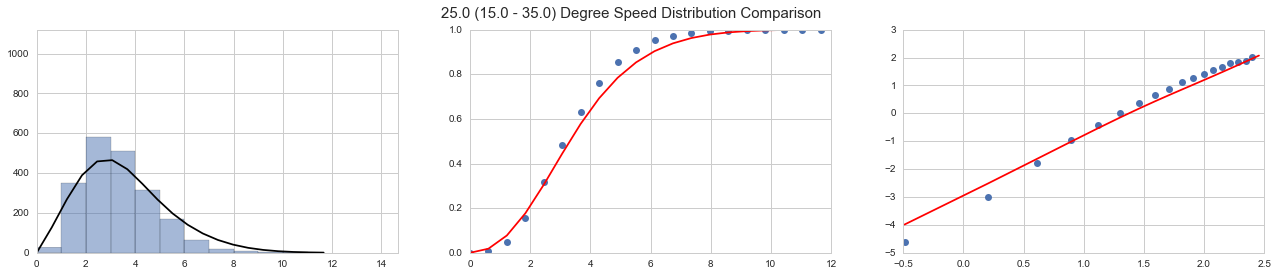

 data size: 2053
max diff: 0.0697802932428 , speed value: 4.90636529722 y gmm 0.784092088637

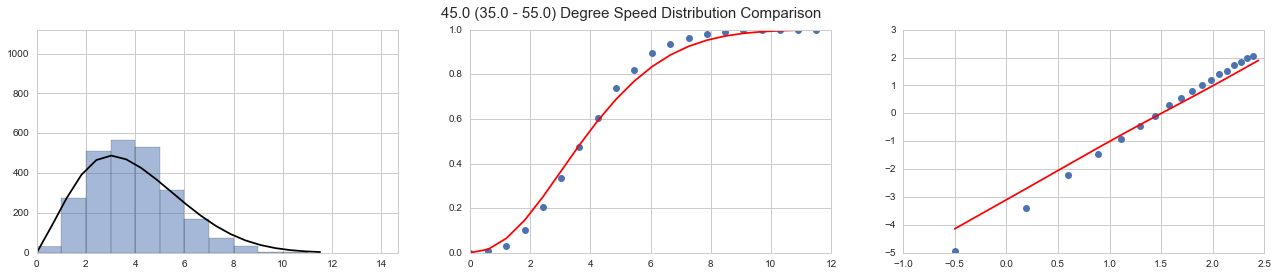

 data size: 2513
max diff: 0.0585917754534 , speed value: 6.0580767132 y gmm 0.834762780854

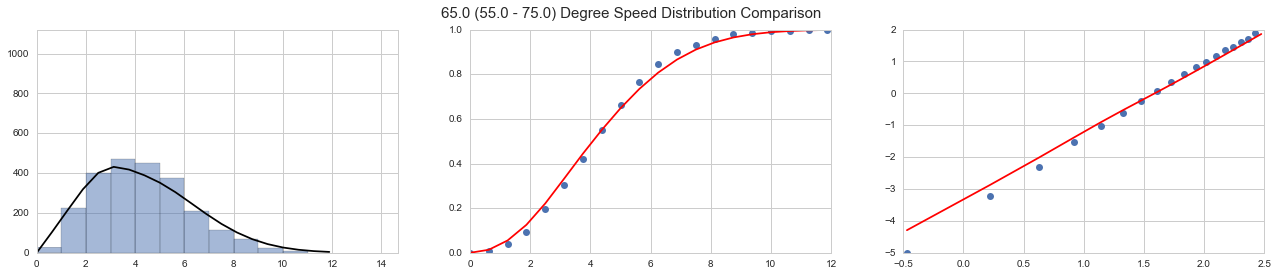

 data size: 2379
max diff: 0.0369371101788 , speed value: 6.25369620619 y gmm 0.807115012562

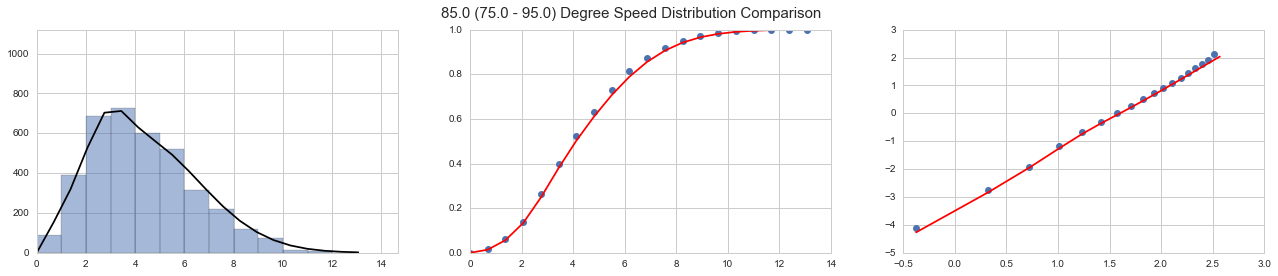

 data size: 3763
max diff: 0.0246974866792 , speed value: 6.18484162503 y gmm 0.789280722197

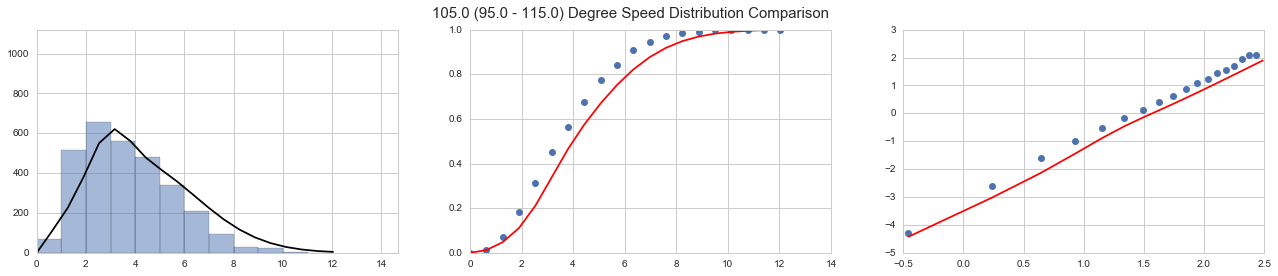

 data size: 2980
max diff: 0.112313665673 , speed value: 3.16670544513 y gmm 0.337686334327

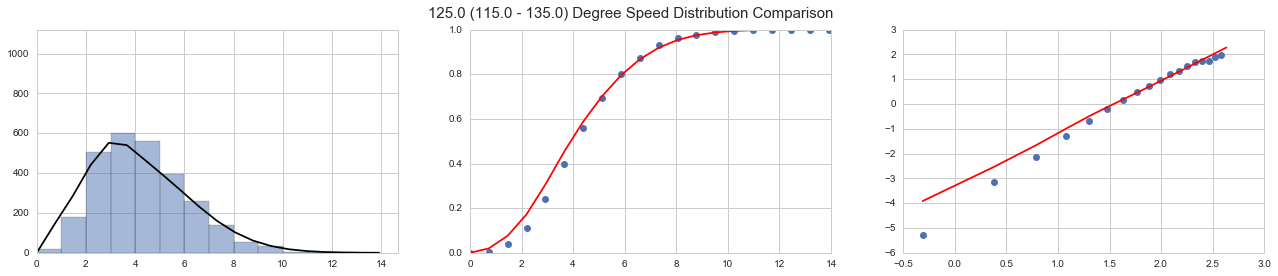

 data size: 2760
max diff: 0.0649519765192 , speed value: 2.92697843081 y gmm 0.306618643186

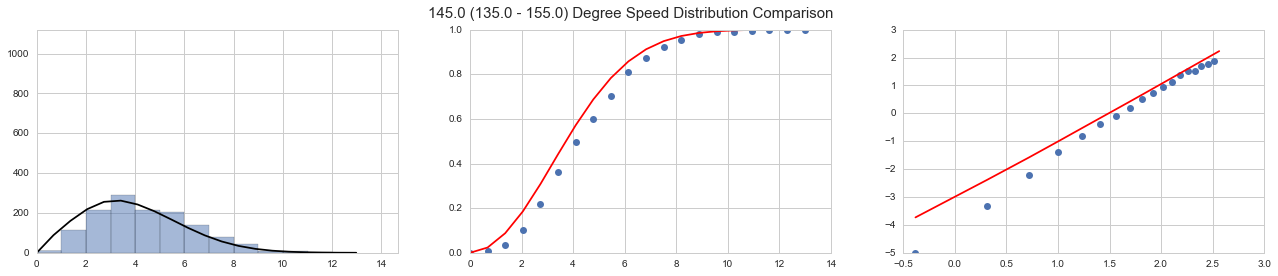

 data size: 1336
max diff: 0.0877596080914 , speed value: 2.73157266671 y gmm 0.307819488331

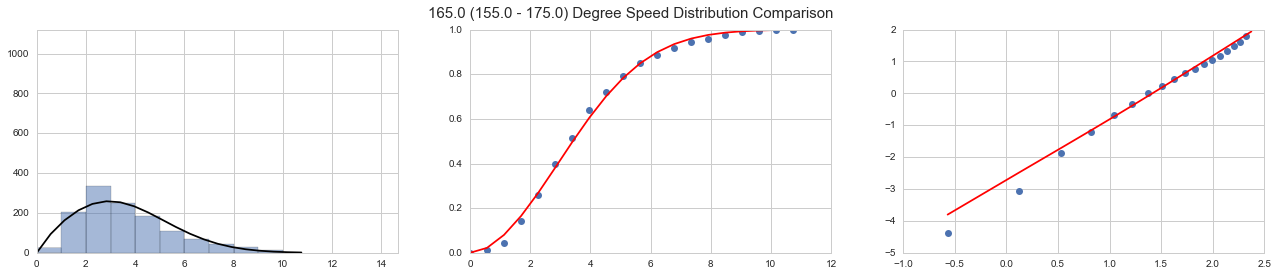

 data size: 1271
max diff: 0.0356328589337 , speed value: 3.95997015275 y gmm 0.604020956959

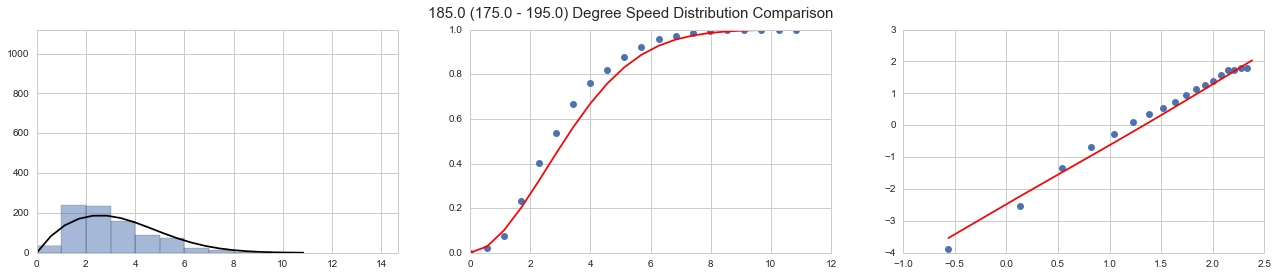

 data size: 876
max diff: 0.105377014251 , speed value: 3.41895200313 y gmm 0.560148099905

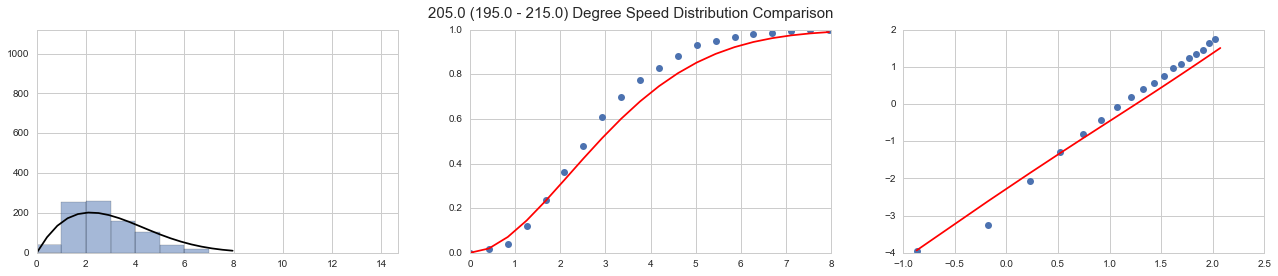

 data size: 885
max diff: 0.0967206483962 , speed value: 3.34969932212 y gmm 0.600454492847

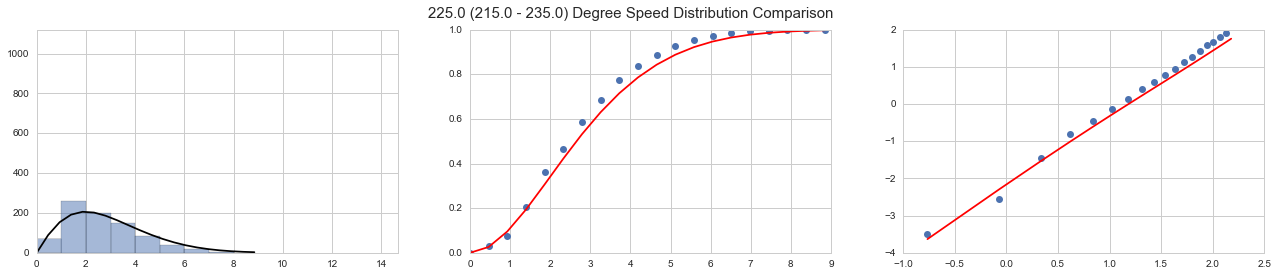

 data size: 828
max diff: 0.059314215281 , speed value: 3.72166371693 y gmm 0.714840374091

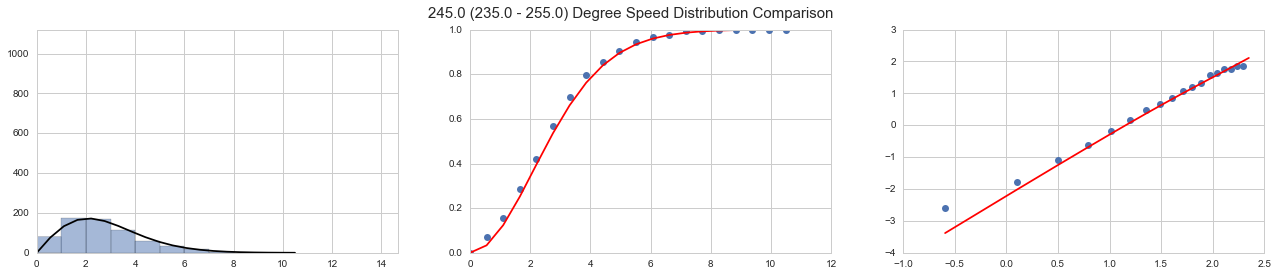

 data size: 655
max diff: 0.0383365298213 , speed value: 0.551979680641 y gmm 0.0334191953695

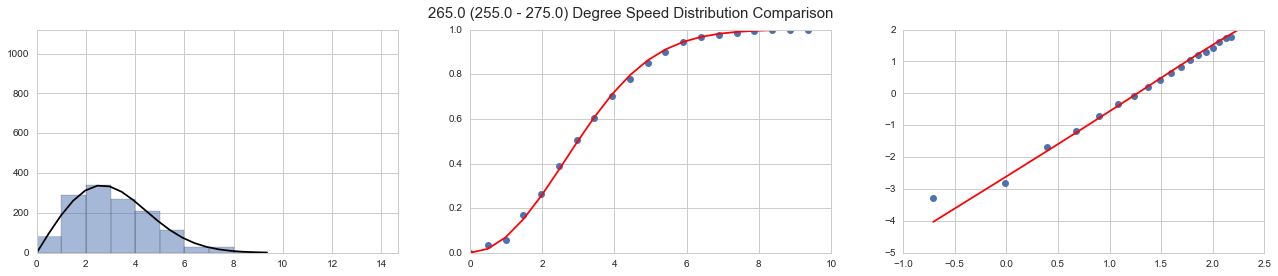

 data size: 1371
max diff: 0.0188815652963 , speed value: 2.46145428029 y gmm 0.37134454703

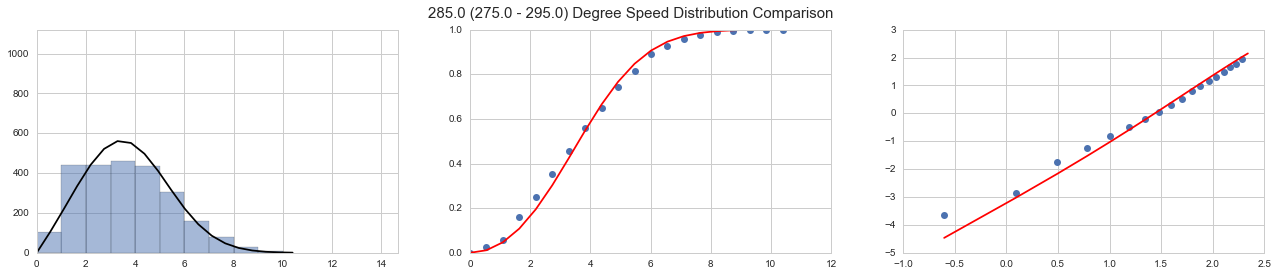

 data size: 2464
max diff: 0.0538573917777 , speed value: 2.18769561283 y gmm 0.194925075755

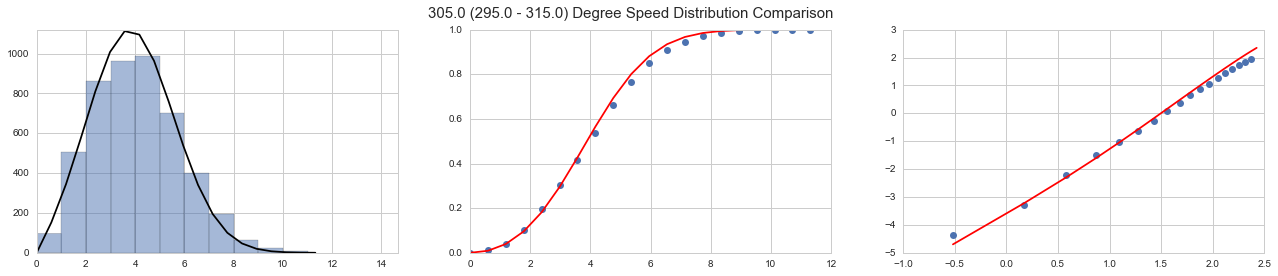

 data size: 4812
max diff: 0.0371871993896 , speed value: 5.3595013806 y gmm 0.800695096314

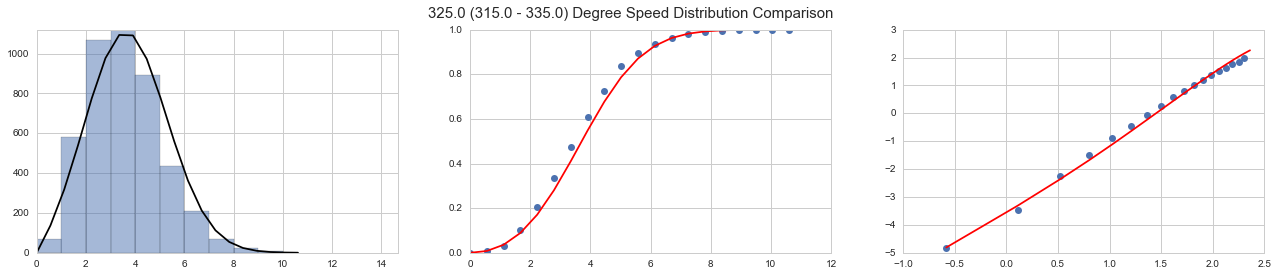

 data size: 4485
max diff: 0.0627934694748 , speed value: 3.35019115316 y gmm 0.410339194962

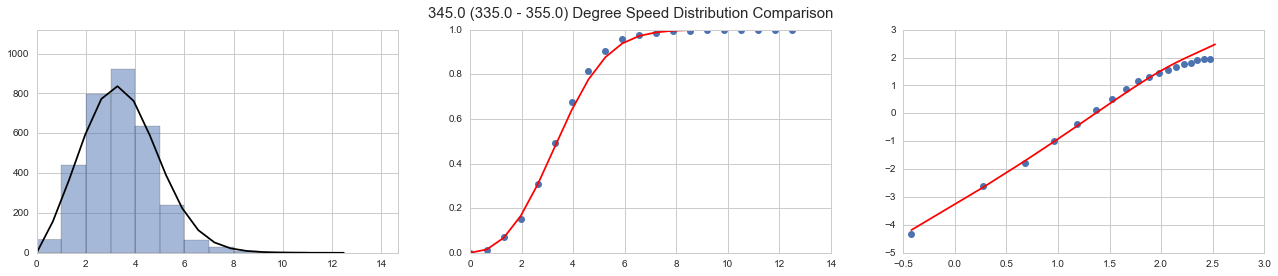

 data size: 3218
max diff: 0.0400763220323 , speed value: 4.59343659225 y gmm 0.776579986234


In [63]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

### 5.3.1 Variance over the years

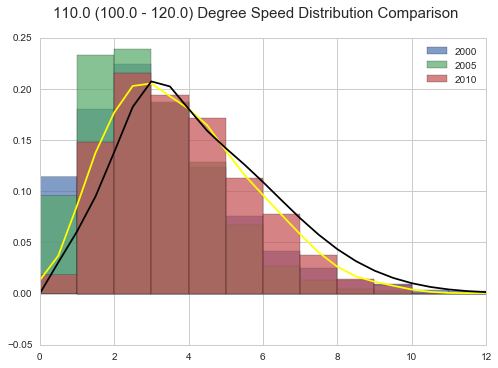

In [54]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), 
                                              normed=True,alpha=0.7,
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

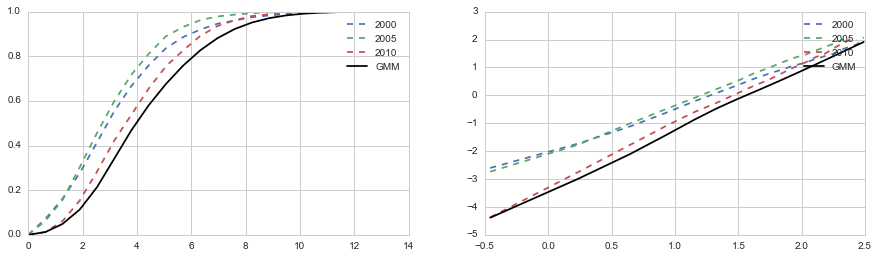

In [55]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,2,1) 
        plt.plot(x, y_cdf,'--', label = str(int(start_time/10000)))

        ax3 = fig.add_subplot(1,2,2) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--', label = str(int(start_time/10000)))
       
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black', label = 'GMM')
plt.legend()

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black',label = 'GMM')
plt.legend()

### 5.3.2 Bootstrap, to see the variance of each sector

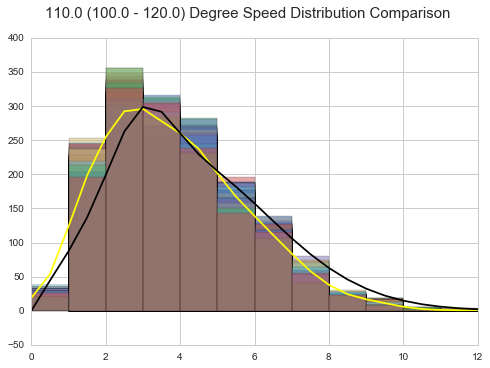

In [56]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.5)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))*len(sub_df.speed)*FRACTION
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

#2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],
                              [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0]/0.2 *len(sub_df.speed)*FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5)

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.0751412948423 5.06672871221 0.675553149602


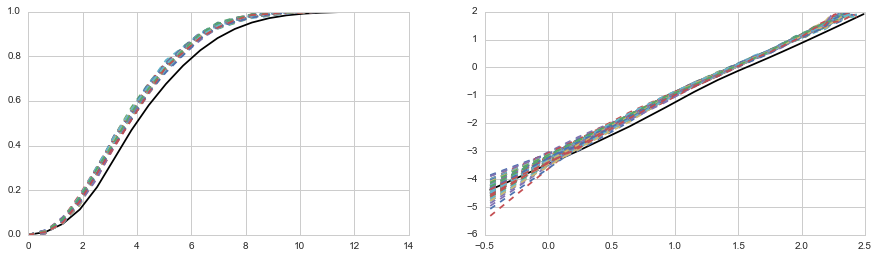

In [57]:
fig = plt.figure(figsize=(15,4))

x = linspace(0, max_speed, 20)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,2,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax3 = fig.add_subplot(1,2,2) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,2,1) 
    plt.plot(x, y_cdf,'--')

    ax3 = fig.add_subplot(1,2,2) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# 6. Variance of results & Cross Validation

In [58]:
from sklearn.cross_validation import train_test_split, KFold

if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
    
points = FITTING_RANGE
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error'):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))
    
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-fit_limit, fit_limit),
             (-fit_limit, fit_limit),(0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
#             {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#             {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
           ]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, points, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)  
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_clf': kde,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit,
    }

## 6.1 Variance of the Result

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.565863,0.054993,1.827892,2.774448,3.118354,0.050447
2,0.379123,2.273484,-1.935488,1.607566,1.922125,-0.075470
3,0.055014,-0.460594,2.846548,1.826712,0.921681,-0.235490


GMM Plot Result
0.565862700997 [[ 0.05499325  1.82789176]] [ 2.75818156  3.13275159] 168.3485575
0.379123102991 [[ 2.27348371 -1.93548772]] [ 1.59288352  1.93431044] -168.607187673
0.0550141960128 [[-0.46059405  2.84654844]] [ 0.88759615  1.84351492] -98.8409797134


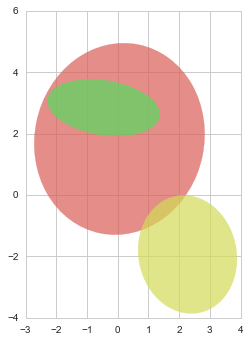

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.025401,0.011629,3.273624e-07,0.023281,0.166656,0.986695


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.559395,0.052781,1.700697,2.741154,3.222582,0.015193
2,0.365667,2.326297,-1.862519,1.578523,1.900806,-0.090229
3,0.074939,-0.251977,2.896357,2.260800,1.042286,-0.068863


GMM Plot Result
0.559394675355 [[ 0.05278125  1.7006969 ]] [ 2.74001221  3.22355304] 177.329477767
0.36566657982 [[ 2.32629688 -1.86251932]] [ 1.55877944  1.91703065] -167.112723694
0.0749387448258 [[-0.25197682  2.89635669]] [ 1.03914771  2.26224448] -92.3049857211


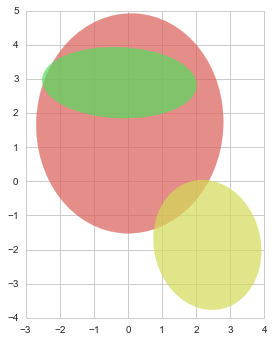

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.027501,0.011471,2.742807e-07,0.021314,0.152688,0.988823


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.591380,0.055285,1.963007,2.776269,2.995902,0.002694
2,0.378859,2.272038,-1.944796,1.615563,1.977981,-0.073532
3,0.029762,-0.428761,2.672940,0.995534,0.801853,-0.008616


GMM Plot Result
0.59137950654 [[ 0.05528545  1.96300745]] [ 2.77619784  2.995968  ] 178.987781869
0.378858586897 [[ 2.27203773 -1.94479552]] [ 1.60279292  1.98834275] -170.07913953
0.0297619065627 [[-0.42876107  2.67293968]] [ 0.80176793  0.99560186] -91.1314357572


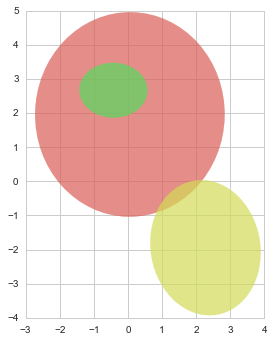

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022695,0.014954,2.690758e-07,0.021539,0.151195,0.988992


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.579120,0.098894,1.905047,2.793379,3.092613,0.012711
2,0.371702,2.240937,-1.926495,1.609225,1.915148,-0.033377
3,0.049177,-0.477991,2.737307,1.560540,0.925745,-0.127766


GMM Plot Result
0.579120491481 [[ 0.09889427  1.90504651]] [ 2.79215799  3.09371539] 176.446130412
0.371702008762 [[ 2.24093699 -1.92649467]] [ 1.60619994  1.91768543] -174.598683889
0.0491774997569 [[-0.47799113  2.73730736]] [ 0.91416873  1.56734907] -96.5823337126


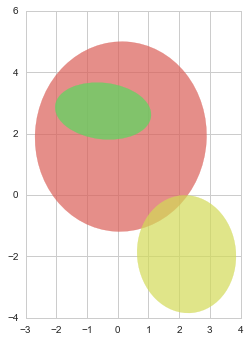

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.030693,0.014656,3.063011e-07,0.022566,0.161351,0.987479


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.597301,0.063413,1.856230,2.765343,3.054178,0.001990
2,0.369057,2.274970,-1.947719,1.599852,1.935770,-0.057935
3,0.033642,-0.400768,2.727343,1.088058,0.820992,-0.044986


GMM Plot Result
0.597300814412 [[ 0.06341314  1.85622992]] [ 2.7653131   3.05420561] 179.427309574
0.369056901683 [[ 2.27496985 -1.94771896]] [ 1.59154383  1.94260611] -171.594191725
0.0336422839049 [[-0.40076814  2.72734279]] [ 0.81907244  1.08950412] -94.4791751345


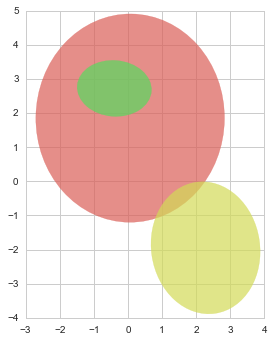

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.02613,0.013177,2.849474e-07,0.021778,0.155489,0.988461


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.565986,0.031180,1.826250,2.745834,3.115289,0.030295
2,0.379768,2.313126,-1.942374,1.603177,1.962572,-0.084742
3,0.054246,-0.209293,2.764061,1.942314,0.910989,-0.102079


GMM Plot Result
0.565985732392 [[ 0.03117981  1.82625031]] [ 2.74025957  3.1201935 ] 173.269788917
0.379768216037 [[ 2.3131257  -1.94237375]] [ 1.58647884  1.97609476] -168.703522229
0.0542460515717 [[-0.20929332  2.76406068]] [ 0.90490682  1.94515549] -93.4992971419


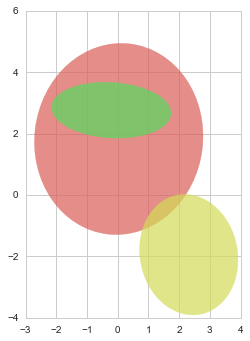

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021857,0.010292,2.801484e-07,0.02187,0.154298,0.988559


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.519370,2.050773,-1.693367,1.753215,2.116495,-0.112578
2,0.369569,-0.028471,2.985756,2.992449,2.084798,-0.023012
3,0.111062,-1.318309,1.209946,1.786000,3.191019,0.727405


GMM Plot Result
0.519369568851 [[ 2.05077278 -1.69336725]] [ 1.72017343  2.1434359 ] -164.638185019
0.369568608195 [[-0.02847091  2.98575588]] [ 2.08372637  2.99319539] -91.7826061112
0.111061822954 [[-1.31830852  1.20994589]] [ 1.1238446  3.4798525] 155.072167343


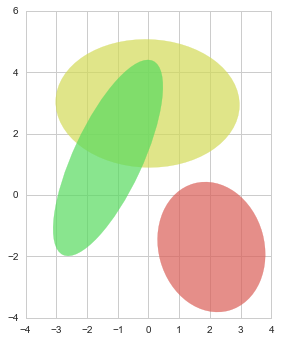

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021985,0.008002,3.040674e-07,0.022861,0.160746,0.987617


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.581004,0.105810,1.787264,2.827997,3.105886,0.010645
2,0.368185,2.315074,-1.936948,1.579985,1.973750,-0.077454
3,0.050811,-0.439595,2.807793,1.564777,0.919017,-0.030175


GMM Plot Result
0.581003858113 [[ 0.10581     1.78726414]] [ 2.82706243  3.10673646] 176.764900858
0.368184869731 [[ 2.31507446 -1.93694837]] [ 1.56711011  1.98398828] -170.477085265
0.0508112721568 [[-0.43959514  2.80779295]] [ 0.91837878  1.56515169] -91.5485752906


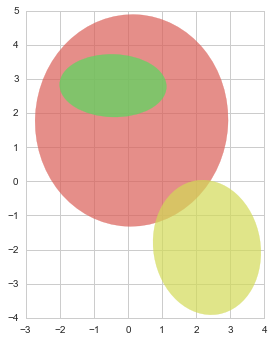

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.021458,0.012495,2.771190e-07,0.021571,0.153416,0.988585


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.598565,0.090952,1.884343,2.792922,2.999602,0.026210
2,0.367764,2.263760,-2.000135,1.592486,1.914013,-0.067386
3,0.033671,-0.589917,2.688275,1.110250,0.813908,-0.054341


GMM Plot Result
0.598565421679 [[ 0.09095174  1.88434291]] [ 2.7859309   3.00609658] 169.927793037
0.367763684097 [[ 2.26376027 -2.00013524]] [ 1.58106239  1.92346017] -169.990120794
0.0336708942243 [[-0.58991684  2.68827535]] [ 0.8113252  1.1121389] -94.8861751292


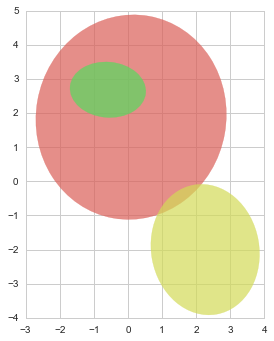

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029545,0.015824,2.995294e-07,0.022731,0.15945,0.987813


,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.595977,0.019581,1.941125,2.777074,3.001487,0.019084
2,0.378626,2.296729,-2.001619,1.597007,1.976293,-0.086350
3,0.025397,-0.377290,2.658732,0.887471,0.753300,-0.054621


GMM Plot Result
0.595976883858 [[ 0.01958075  1.94112471]] [ 2.77361036  3.00468827] 173.107871686
0.37862605823 [[ 2.29672876 -2.00161852]] [ 1.58040568  1.9895941 ] -169.045660069
0.0253970579117 [[-0.37729013  2.65873161]] [ 0.749374    0.89078807] -99.1765239133


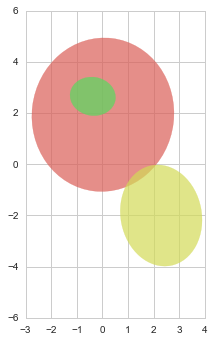

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022622,0.014059,2.803799e-07,0.021805,0.154364,0.988483


In [59]:
for i in range(10):
    df_resampled = df.sample(frac=1, replace=True)
    result = fit_gmm(df_resampled, NUMBER_OF_GAUSSIAN, fit_method = FIT_METHOD)
    display(pretty_print_gmm(result['gmm']))
    plot_gmm_ellipses(result['gmm'])
    pretty_pd_display([goodness_of_fit_summary(result['gmm_pdf_result'], result['kde_result'])])

## 6.2 Cross validation, to select the number of Gaussian

In [60]:
## 5-fold cross validation
gaussian_number_range = arange(1,7)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        CV_result_train.append(gof_train)
        CV_result_test.append(gof_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print 'Train'
    pretty_pd_display(CV_result_train)
    print 'Test'
    pretty_pd_display(CV_result_test)

Number of train/test dataset 30427.5 10142.5
  
Number of gaussian 1
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.089831,0.051841,0.000002,0.063123,0.444855,0.904292
1,0.090985,0.053502,0.000002,0.064308,0.453219,0.901321
2,0.093178,0.055167,0.000002,0.064940,0.459980,0.897919
3,0.091024,0.052135,0.000002,0.063595,0.451633,0.902435


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.097766,0.056671,0.000003,0.067788,0.483866,0.889212
1,0.100092,0.045973,0.000002,0.061871,0.441571,0.905821
2,0.088536,0.055593,0.000002,0.062599,0.440102,0.907763
3,0.099285,0.057031,0.000002,0.065961,0.460063,0.896407


  
Number of gaussian 2
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.029034,0.018154,4.006937e-07,0.026143,0.184556,0.983537
1,0.029809,0.018206,4.010957e-07,0.025808,0.184519,0.983686
2,0.026837,0.016705,4.003743e-07,0.026241,0.184421,0.983660
3,0.029113,0.018033,4.147252e-07,0.026662,0.187778,0.983013


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.035558,0.012766,5.007369e-07,0.029024,0.206120,0.979878
1,0.030348,0.017371,5.022214e-07,0.030284,0.206862,0.979200
2,0.044261,0.024988,4.824390e-07,0.028144,0.202521,0.980213
3,0.029887,0.024420,4.601994e-07,0.027623,0.197542,0.981337


  
Number of gaussian 3
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.022759,0.013694,2.965989e-07,0.022409,0.158676,0.987925
1,0.024241,0.015009,2.587148e-07,0.021017,0.148332,0.989359
2,0.023110,0.015841,2.790073e-07,0.021624,0.153961,0.988718
3,0.025595,0.012011,2.739330e-07,0.021728,0.152564,0.988694


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.023650,0.010351,2.656952e-07,0.021381,0.150452,0.989009
1,0.031592,0.022618,3.892463e-07,0.025553,0.181604,0.984393
2,0.033422,0.017365,3.552112e-07,0.025107,0.173746,0.985015
3,0.028243,0.015940,3.752422e-07,0.024744,0.178545,0.985109


  
Number of gaussian 4


KeyboardInterrupt: 

In [ ]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print 'Train gof mean, std'
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print 'Test gof mean, std'
display(test_scores_mean)

In [ ]:
prop_cycle=sns.color_palette()
for column in ['R_square','K_S','Chi_square', ]:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, train_scores_mean[column],
             '-', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plt.plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.legend()
    plt.show()

## 6.3 Variance of KDE

In [ ]:
sss

In [ ]:
gmm1 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,
        0.055879,1.009152,-1.430799,2.10049,0.808011,0.08083,
        0.019425,-0.432981,2.574572,0.784784,0.796954,-0.020531]

gmm2 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,
        0.372591,2.376362,-2.098443,1.621717,2.213625,-0.01429,]

gmm3 = [0.552104,-0.055681,2.256591,2.757752,2.731348,0.034628,]

gmms = [gmm1,gmm2,gmm3]
pdfs =[]

for gmm in gmms:
    plot_gmm_ellipses(gmm)
    gmm = group_gmm_param_from_gmm_param_array(gmm) 
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    X = Y = PLOT_AXIS_RANGE
    pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
    pdfs.append(pdf_Z)
    plot_2d_prob_density(X,Y,pdf_Z)

In [ ]:
plot_2d_prob_density(X,Y,pdfs[0]-pdfs[1])

In [ ]:
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    sub_df = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    sample = sub_speed_set = array(zip(sub_df.x, sub_df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    
    X = Y = PLOT_AXIS_RANGE
    kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    plot_2d_prob_density(X,Y,kde_Z,ax)
    plt.show()
#     plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir)

In [ ]:
# 5-fold cross validation
gaussian_number_range = arange(3,5)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_train = result['kde_clf']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        # Plot jPDF
        X = Y = PLOT_AXIS_RANGE
        kde_train_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_train.score_samples(coords)))
        fig = plt.figure(figsize=(22,6))
        ax1 = fig.add_subplot(1,3,1)
        plot_2d_prob_density(X,Y,kde_train_Z, ax1)
        
        ax2 = fig.add_subplot(1,3,2)
        kde_test_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_test.score_samples(coords)))
        plot_2d_prob_density(X,Y,kde_test_Z, ax2)
            
        ax3 = fig.add_subplot(1,3,3)
        plot_2d_prob_density(X,Y,kde_train_Z-kde_test_Z,ax3)
        
        pretty_pd_display([gof_train, gof_test], index=["gof_train", "gof_test"]))
        